In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score,r2_score,mean_squared_error, recall_score, precision_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
drugs = pd.read_csv('/content/drive/MyDrive/데마 팀플/기말 Project/DATA/regression_2.csv')
drugs.dropna(inplace=True)

In [ ]:
columns_to_scale = ['CF0.01', 'CV', 'COUNT', 'DD_MQTY_FREQ',
                    'DD_EXEC_FREQ', 'MDCN_EXEC_FREQ', 'UN_COST'] # 'Rebate'

sd_scaler = StandardScaler()
sd_scaler.fit(drugs[columns_to_scale])
drugs[columns_to_scale] = sd_scaler.transform(drugs[columns_to_scale])
drugs

,5_GNL,CF0.01,CV,COUNT,Rebate,DD_MQTY_FREQ,DD_EXEC_FREQ,MDCN_EXEC_FREQ,UN_COST
0,1001A,-1.169336,-1.166311,-0.272638,0,-0.066415,2.055352,0.843320,-0.215302
1,1003A,0.897197,0.659595,-0.202491,0,-0.162494,0.754120,0.204916,-0.240102
2,1005A,-0.537303,-0.353984,-0.265099,0,-0.072970,0.769562,-0.123137,-0.246039
3,1006A,0.268715,0.331380,-0.250062,0,-0.162738,0.921581,0.838781,-0.248917
4,1007A,1.699665,1.629995,0.537116,0,-0.170354,0.791236,-0.541347,-0.244097
...,...,...,...,...,...,...,...,...,...
1407,8002C,-1.094770,-1.055617,-0.270089,0,8.368016,-0.704801,-0.918152,-0.216093
1408,8005C,-0.995349,-1.010531,-0.271329,0,-0.145117,-0.774816,-1.025614,1.097158
1409,8009C,-1.030857,-1.005169,-0.263476,0,-0.003311,-0.681254,-1.017319,0.571477
1410,8010C,-1.073465,-1.084423,-0.266664,0,-0.005981,-0.807700,-1.015685,0.754347


In [ ]:
drugs.set_index('5_GNL', inplace=True)
X = drugs[['CF0.01', 'CV', 'COUNT', 'DD_MQTY_FREQ', 'DD_EXEC_FREQ', 'MDCN_EXEC_FREQ', 'UN_COST']]
y = drugs['Rebate']

In [ ]:
# Split the data into training and testing sets (85% train, 15% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=132)

In [ ]:
from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler
x_shuffled = shuffle(X_train, random_state=132)
y_shuffled = shuffle(y_train, random_state=132)
counts = y_shuffled.value_counts()
total_of_classes_0 = 9 * (counts[1])

# 언더 샘플링 설정
sampling_strategy = {0: total_of_classes_0, 1: counts[1]}

# RandomUnderSampler를 사용하여 지정된 비율로 언더 샘플링을 수행합니다.
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=132)
X_train_us, y_train_us = rus.fit_resample(x_shuffled, y_shuffled)

# 결과 확인
pd.DataFrame(y_train_us).value_counts()

Rebate
0         225
1          25
Name: count, dtype: int64

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
import numpy as np

# RandomForestClassifier를 정의합니다.
rf_model = RandomForestClassifier(random_state=132)

# 하이퍼파라미터 그리드 설정
rf_params = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [None, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

# RandomizedSearchCV 설정
random_search_rf = RandomizedSearchCV(estimator=rf_model,
                                      param_distributions=rf_params,
                                      n_iter=50,  # 시도할 파라미터 조합 수
                                      scoring='f1',  # F1 점수 사용
                                      cv=5,  # 5-겹 교차 검증
                                      verbose=1,  # 진행 과정을 출력
                                      random_state=132,
                                      n_jobs=-1)  # 병렬 처리 개수(-1은 가능한 모든 코어 사용)

# 모델을 학습 데이터에 적합시킵니다.
random_search_rf.fit(X_train_us, y_train_us)

# 최적의 파라미터와 최고 점수 출력
print("Best Parameters:", random_search_rf.best_params_)
print("Best Score:", random_search_rf.best_score_)

# 최적의 모델로 예측
best_rf_model = random_search_rf.best_estimator_

# 검증 세트에서 모델 평가
val_predictions = best_rf_model.predict(X_test)
print("Validation F1 Score:", f1_score(y_test, val_predictions, average='binary'))

# 테스트 세트에서 모델 평가
test_predictions = best_rf_model.predict(X_test)
print("Test F1 Score:", f1_score(y_test, test_predictions, average='binary'))


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
Best Score: 0.31428571428571433
Validation F1 Score: 0.4615384615384615
Test F1 Score: 0.4615384615384615


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 평가 지표 출력
print('정확도 accuracy: %.3f' % accuracy_score(y_test, test_predictions))
print('정밀도 precision: %.3f' % precision_score(y_test, test_predictions, average='binary'))
print('재현율 recall: %.3f' % recall_score(y_test, test_predictions, average='binary'))
print('F1-score: %.3f' % f1_score(y_test, test_predictions, average='binary'))
print('ROC AUC score: %.3f' % roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1]))

정확도 accuracy: 0.966
정밀도 precision: 0.500
재현율 recall: 0.429
F1-score: 0.462
ROC AUC score: 0.802


In [ ]:
import pandas as pd

# Get feature importance
feature_importance = best_rf_model.feature_importances_

# Create a DataFrame to view the features and their importance scores
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Sort the DataFrame based on importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display the feature importance
features_df

,Feature,Importance
0,CF0.01,0.231062
5,MDCN_EXEC_FREQ,0.201161
1,CV,0.125672
2,COUNT,0.122750
3,DD_MQTY_FREQ,0.107230
6,UN_COST,0.106685
4,DD_EXEC_FREQ,0.105441


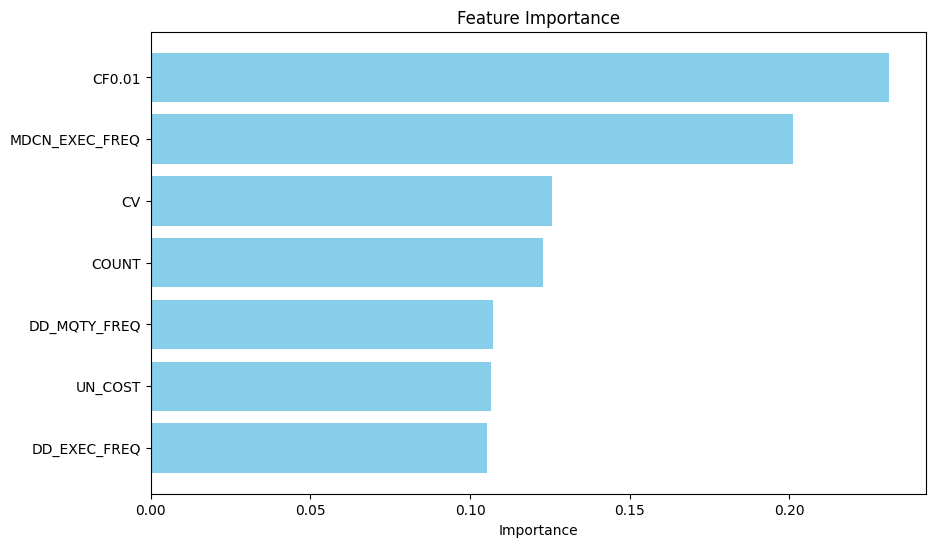

In [ ]:
# Sorting the DataFrame based on importance
features_df.sort_values(by='Importance', ascending=True, inplace=True)

# Plotting the feature importance as a bar graph
plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'], features_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

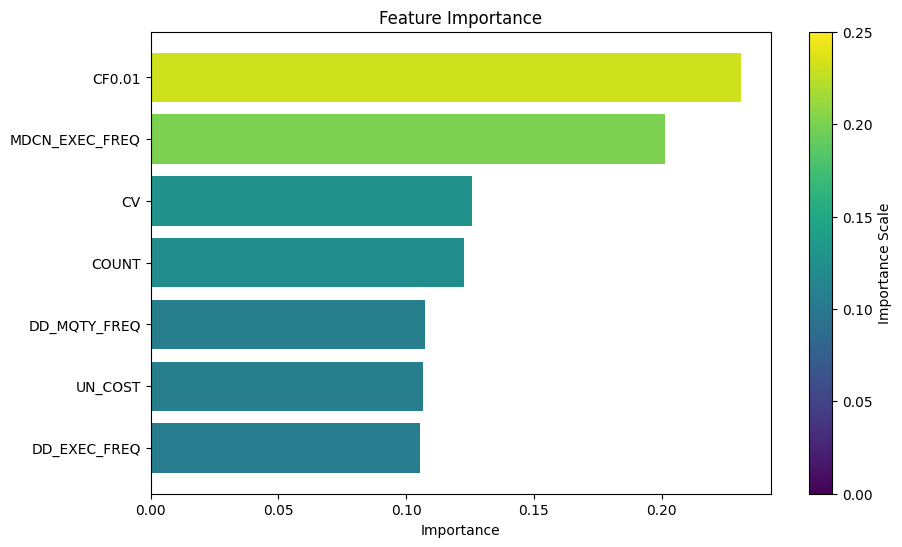

In [ ]:
# Normalize the importance values for consistent color mapping
norm = plt.Normalize(vmin=0, vmax=0.25)  # Adjust the maximum to slightly above the highest importance to enhance color distinction

# Apply the viridis colormap
colors = plt.cm.viridis(norm(features_df['Importance']))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(features_df['Feature'], features_df['Importance'], color=colors)
ax.set_xlabel('Importance')
ax.set_title('Feature Importance')

# Create a colorbar with the same normalization and colormap
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax)
cbar.set_label('Importance Scale')

plt.show()